In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import backend as K
# os.environ["CUDA_VISIBLE_DEVICES"] = '2'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

from keras.regularizers import l2
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, Lambda, Dropout
from keras.layers import SeparableConv2D, Add, Convolution2D, concatenate, Layer, ReLU, DepthwiseConv2D, Reshape, Multiply, InputSpec
from keras.models import Model, load_model, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
from PIL import Image
from tqdm import tqdm, trange
import random
from keras.applications import Xception
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [2]:
nb_classes = 2  # number of classes
img_width, img_height = 64, 64  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 300  # number of iteration the algorithm gets trained.

# Dir

In [3]:
train_dir = '/mnt/a/fakedata/deepfake/train'
validation_dir = '/mnt/a/fakedata/deepfake/val'
test50_dir = '/mnt/a/fakedata/deepfake/test'

# Xception

In [4]:
def xception(include_top=True):

    img_input = Input(shape=(img_height, img_width, 3))

    # layer 1 #
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='valid', use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # layer 2 #
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # skip layer 1 #
    res = Conv2D(filters=128, kernel_size=(1, 1), strides=2, padding='same', use_bias=False)(x)
    res = BatchNormalization()(res)

    # layer 3 #
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # layer 4 #
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Add()([x, res])

    # skip layer 2 #
    res = Conv2D(filters=256, kernel_size=(1, 1), strides=2, padding='same', use_bias=False)(x)
    res = BatchNormalization()(res)

    # layer 5 #
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # layer 6 #
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Add()([x, res])

    # skip layer 3 #
    res = Conv2D(filters=728, kernel_size=(1, 1), strides=2, padding='same', use_bias=False)(x)
    res = BatchNormalization()(res)

    # layer 7 #
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # layer 8 #
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=728, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Add()([x, res])

    # ======== middle flow ========= #
    for i in range(8):
        # layer 9, 10, 11, 12, 13, 14, 15, 16, 17 #
        res = x

        x = Activation('relu')(x)
        x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)    

        x = Activation('relu')(x)
        x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = Add()([x, res])    

    # ======== exit flow ========== #
    # skip layer 4 #
    res = Conv2D(filters=1024, kernel_size=(1, 1), strides=2, padding='same', use_bias=False)(x)
    res = BatchNormalization()(res)

    # layer 18 #
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=728, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # layer 19 #
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=1024, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Add()([x, res])

    # layer 20 #
    x = SeparableConv2D(filters=1536, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # layer 21 #
    x = SeparableConv2D(filters=2048, kernel_size=(3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    x_gap = GlobalAveragePooling2D()(x)
    output = Dense(units=2, activation='softmax')(x_gap)

    if include_top:
        model = Model(img_input, output)
    else:
        model = Model(img_input, x)
#     model.summary()
    return model

In [5]:
def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Data generator

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=bgr)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=bgr)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 60000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [7]:
# callback_list = [EarlyStopping(monitor='val_accuracy', patience=10),
#                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]
# history = model.fit_generator(train_generator,
#                             steps_per_epoch=200,
#                             epochs=100,
#                             validation_data=validation_generator,
#                             validation_steps=len(validation_generator),
#                             callbacks=callback_list)

In [8]:
# model.save('/home/www/fake_detection/model/deepfake_xception.h5')

In [9]:
# model = load_model('/home/www/fake_detection/model/deepfake_xception.h5')

In [10]:
# output = model.predict_generator(test50_generator, steps=len(test50_generator), verbose=1)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# print(test50_generator.class_indices)
# print(output)

In [11]:
# output_score50 = []
# output_class50 = []
# answer_class50 = []
# answer_class50_1 =[]

# for i in trange(len(test50_generator)):
#     output50 = model.predict_on_batch(test50_generator[i][0])
#     output_score50.append(output50)
#     answer_class50.append(test50_generator[i][1])
    
# output_score50 = np.concatenate(output_score50)
# answer_class50 = np.concatenate(answer_class50)

# output_class50 = np.argmax(output_score50, axis=1)
# answer_class50_1 = np.argmax(answer_class50, axis=1)

# print(output_class50)
# print(answer_class50_1)

In [12]:
# cm50 = confusion_matrix(answer_class50_1, output_class50)
# report50 = classification_report(answer_class50_1, output_class50)

# recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
# fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

# fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
# eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
# thresh50 = interp1d(fpr50, thresholds50)(eer50)

# print(report50)
# print(cm50)
# print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
# print(thresh50)
# print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

In [13]:
def cutout(img):
    """
    # Function: RandomCrop (ZeroPadded (4, 4)) + random occulusion image
    # Arguments:
        img: image
    # Returns:
        img
    """
    img = bgr(img)
    height = img.shape[0]
    width = img.shape[1]
    channels = img.shape[2]
    MAX_CUTS = 3 # chance to get more cuts
    MAX_LENGTH_MUTIPLIER = 10 # chance to get larger cuts
    # 16 for cifar10, 8 for cifar100
    
    # Zero-padded (4, 4)
#     img = np.pad(img, ((4,4),(4,4),(0,0)), mode='constant', constant_values=(0))
    
#     # random-crop 64x64
#     dy, dx = height, width
#     x = np.random.randint(0, width - dx + 1)
#     y = np.random.randint(0, height - dy + 1)
#     img = img[y:(y+dy), x:(x+dx)]
    
#     mean norm
#     mean = img.mean(keepdims=True)
#     img -= mean

    img *= 1./255
    
    mask = np.ones((height, width, channels), dtype=np.float32)
    nb_cuts = np.random.randint(0, MAX_CUTS + 1)
    
    # cutout
    for i in range(nb_cuts):
        y = np.random.randint(height)
        x = np.random.randint(width)
        length = 4 * np.random.randint(1, MAX_LENGTH_MUTIPLIER+1)
        
        y1 = np.clip(y-length//2, 0, height)
        y2 = np.clip(y+length//2, 0, height)
        x1 = np.clip(x-length//2, 0, width)
        x2 = np.clip(x+length//2, 0, width)
        
        mask[y1:y2, x1:x2, :] = 0.
    
    img = img * mask
    return img

In [14]:
class ReLU6(Layer):
    def __init__(self):
        super().__init__(name="ReLU6")
        self.relu6 = ReLU(max_value=6, name="ReLU6")

    def call(self, input):
        return self.relu6(input)


class HardSigmoid(Layer):
    def __init__(self):
        super().__init__()
        self.relu6 = ReLU6()

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0


class HardSwish(Layer):
    def __init__(self):
        super().__init__()
        self.hard_sigmoid = HardSigmoid()

    def call(self, input):
        return input * self.hard_sigmoid(input)
    
class Attention(Layer):
    def __init__(self, ch, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        print(kernel_shape_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f')
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g')
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h')
        self.bias_f = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_F')
        self.bias_g = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_g')
        self.bias_h = self.add_weight(shape=(self.filters_h,),
                                      initializer='zeros',
                                      name='bias_h')
        super(Attention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True


    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        f = K.bias_add(f, self.bias_f)
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.bias_add(g, self.bias_g)
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]
        h = K.bias_add(h, self.bias_h)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape

# w/o MB

In [15]:
ft_dir = '/mnt/a/fakedata/deepfake/finetune'
train_gen_aug = ImageDataGenerator(shear_range=0, 
                               zoom_range=0,
                               rotation_range=0.2,
                               width_shift_range=2., 
                               height_shift_range=2.,
                               horizontal_flip=True,
                               zca_whitening=False,
                               fill_mode='nearest',
                               preprocessing_function=cutout)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=bgr)

ft_gen = train_gen_aug.flow_from_directory(ft_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [16]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

model_ft = load_model('/home/www/fake_detection/model/deepfake_xception.h5')
for i in range(2):
    model_ft.layers.pop()
im_in = Input(shape=(img_width, img_height, 3))

base_model = xception(include_top=False)
base_model.set_weights(model_ft.get_weights())
    
x1 = base_model(im_in) # (12, 12, 32)
########### Mobilenet block bneck 3x3 (32 --> 128) #################
# expand1 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(x1)
# expand1 = BatchNormalization()(expand1)
# expand1 = HardSwish()(expand1)
# dw1 = DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand1)
# dw1 = BatchNormalization()(dw1)
# se_gap1 = GlobalAveragePooling2D()(dw1)
# se_gap1 = Reshape([1, 1, -1])(se_gap1)
# se1 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap1)
# se1 = Activation('relu')(se1)
# se1 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se1)
# se1 = HardSigmoid()(se1)
# se1 = Multiply()([expand1, se1])
# project1 = HardSwish()(se1)
# project1 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
# project1 = BatchNormalization()(project1)

# ########### Mobilenet block bneck 5x5 (128 --> 128) #################
# expand2 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project1)
# expand2 = BatchNormalization()(expand2)
# expand2 = HardSwish()(expand2)
# dw2 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand2)
# dw2 = BatchNormalization()(dw2)
# se_gap2 = GlobalAveragePooling2D()(dw2)
# se_gap2 = Reshape([1, 1, -1])(se_gap2)
# se2 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap2)
# se2 = Activation('relu')(se2)
# se2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se2)
# se2 = HardSigmoid()(se2)
# se2 = Multiply()([expand2, se2])
# project2 = HardSwish()(se2)
# project2 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project2)
# project2 = BatchNormalization()(project2)
# project2 = Add()([project1, project2])

# ########### Mobilenet block bneck 5x5 (128 --> 128) #################
# expand3 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project2)
# expand3 = BatchNormalization()(expand3)
# expand3 = HardSwish()(expand3)
# dw3 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand3)
# dw3 = BatchNormalization()(dw3)
# se_gap3 = GlobalAveragePooling2D()(dw3)
# se_gap3 = Reshape([1, 1, -1])(se_gap3)
# se3 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap3)
# se3 = Activation('relu')(se3)
# se3 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se3)
# se3 = HardSigmoid()(se3)
# se3 = Multiply()([expand3, se3])
# project3 = HardSwish()(se3)
# project3 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# project3 = BatchNormalization()(project3)
# project3 = Add()([project2, project3])

# expand4 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# expand4 = BatchNormalization()(expand4)
# expand4 = HardSwish()(expand4)
# dw4 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand4)
# dw4 = BatchNormalization()(dw4)
# se_gap4 = GlobalAveragePooling2D()(dw4)
# se_gap4 = Reshape([1, 1, -1])(se_gap4)
# se4 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap4)
# se4 = Activation('relu')(se4)
# se4 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se4)
# se4 = HardSigmoid()(se4)
# se4 = Multiply()([expand4, se4])
# project4 = HardSwish()(se4)
# project4 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
# project4 = BatchNormalization()(project4)
# project4 = Add()([project3, project4])


########## Classification ##########
x2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(x1)
x2 = BatchNormalization()(x2)
x2 = HardSwish()(x2)
x2 = GlobalAveragePooling2D()(x2)

# ######### Image Attention Model #########
# ### Block 1 ###
x3 = SeparableConv2D(32, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(im_in)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Attention(32)(x3)

### Block 2 ###
x4 = SeparableConv2D(64, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Attention(64)(x4)

### Block 3 ###
x5 = SeparableConv2D(128, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x4)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = Attention(128)(x5)

### final stage ###
x6 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = GlobalAveragePooling2D()(x6)

######## final addition #########

x2 = Add()([x2, x6])
x2 = Dense(2)(x2)
x2 = Activation('softmax')(x2)

model_top = Model(inputs=im_in, outputs=x2)
model_top.summary()

optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=300), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
output1 = model_top.fit_generator(ft_gen, steps_per_epoch=50, epochs=200,
                                  validation_data=test50_generator, validation_steps=len(test50_generator), callbacks=callback_list)



(1, 1, 32, 4)
(1, 1, 64, 8)
(1, 1, 128, 16)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_35 (SeparableC (None, 32, 32, 32)   123         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 32)   128         separable_conv2d_35[0][0]        
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 32, 32, 32)   0           batch_normalization_39[0][0]     
______________________________________________

50/50 [==============================] - 49s 985ms/step - loss: 0.4063 - acc: 0.8131 - val_loss: 0.6197 - val_acc: 0.8477
Epoch 18/200
50/50 [==============================] - 50s 992ms/step - loss: 0.4180 - acc: 0.8025 - val_loss: 1.0873 - val_acc: 0.8673
Epoch 19/200
50/50 [==============================] - 49s 985ms/step - loss: 0.3792 - acc: 0.8232 - val_loss: 1.0566 - val_acc: 0.8797
Epoch 20/200
50/50 [==============================] - 49s 977ms/step - loss: 0.3511 - acc: 0.8359 - val_loss: 1.0569 - val_acc: 0.8618
Epoch 21/200
50/50 [==============================] - 50s 1000ms/step - loss: 0.3516 - acc: 0.8350 - val_loss: 0.2593 - val_acc: 0.8891
Epoch 22/200
50/50 [==============================] - 49s 987ms/step - loss: 0.3907 - acc: 0.8308 - val_loss: 1.1203 - val_acc: 0.8933
Epoch 23/200
50/50 [==============================] - 49s 978ms/step - loss: 0.3737 - acc: 0.8245 - val_loss: 1.2781 - val_acc: 0.8347
Epoch 24/200
50/50 [==============================] - 49s 980ms/ste

Epoch 78/200
50/50 [==============================] - 49s 989ms/step - loss: 0.1315 - acc: 0.9444 - val_loss: 0.3062 - val_acc: 0.9596
Epoch 79/200
50/50 [==============================] - 50s 1s/step - loss: 0.1574 - acc: 0.9344 - val_loss: 0.3779 - val_acc: 0.9564
Epoch 80/200
50/50 [==============================] - 49s 974ms/step - loss: 0.1660 - acc: 0.9381 - val_loss: 0.1995 - val_acc: 0.9593
Epoch 81/200
50/50 [==============================] - 50s 995ms/step - loss: 0.1574 - acc: 0.9275 - val_loss: 0.5225 - val_acc: 0.9470
Epoch 82/200
50/50 [==============================] - 49s 989ms/step - loss: 0.1544 - acc: 0.9343 - val_loss: 0.3499 - val_acc: 0.9566
Epoch 83/200
50/50 [==============================] - 49s 983ms/step - loss: 0.1341 - acc: 0.9369 - val_loss: 0.2971 - val_acc: 0.9591
Epoch 84/200
50/50 [==============================] - 50s 995ms/step - loss: 0.1489 - acc: 0.9375 - val_loss: 0.5239 - val_acc: 0.9317
Epoch 85/200
50/50 [==============================] - 49s 

50/50 [==============================] - 50s 1s/step - loss: 0.1066 - acc: 0.9577 - val_loss: 0.2284 - val_acc: 0.9671
Epoch 139/200
50/50 [==============================] - 50s 993ms/step - loss: 0.0999 - acc: 0.9596 - val_loss: 0.2416 - val_acc: 0.9664
Epoch 140/200
50/50 [==============================] - 49s 980ms/step - loss: 0.1016 - acc: 0.9571 - val_loss: 0.2182 - val_acc: 0.9660
Epoch 141/200
50/50 [==============================] - 49s 987ms/step - loss: 0.0920 - acc: 0.9602 - val_loss: 0.1893 - val_acc: 0.9679
Epoch 142/200
50/50 [==============================] - 50s 994ms/step - loss: 0.1005 - acc: 0.9609 - val_loss: 0.1960 - val_acc: 0.9689
Epoch 143/200
50/50 [==============================] - 50s 999ms/step - loss: 0.0972 - acc: 0.9575 - val_loss: 0.2181 - val_acc: 0.9663
Epoch 144/200
50/50 [==============================] - 49s 989ms/step - loss: 0.1128 - acc: 0.9558 - val_loss: 0.1772 - val_acc: 0.9669
Epoch 145/200
50/50 [==============================] - 49s 989ms/

50/50 [==============================] - 49s 974ms/step - loss: 0.1126 - acc: 0.9519 - val_loss: 0.2009 - val_acc: 0.9690
Epoch 199/200
50/50 [==============================] - 48s 969ms/step - loss: 0.1095 - acc: 0.9527 - val_loss: 0.1929 - val_acc: 0.9696
Epoch 200/200
50/50 [==============================] - 50s 999ms/step - loss: 0.0897 - acc: 0.9606 - val_loss: 0.1922 - val_acc: 0.9697


In [17]:
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model_top.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

100%|██████████| 625/625 [01:43<00:00,  6.04it/s]

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10000
           1       0.99      0.95      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

[[9889  111]
 [ 494 9506]]
AUROC: 0.995272
0.117774717509746
test_acc:  0.96975


# N = 1

In [18]:
ft_dir = '/mnt/a/fakedata/deepfake/finetune'
train_gen_aug = ImageDataGenerator(shear_range=0, 
                               zoom_range=0,
                               rotation_range=0.2,
                               width_shift_range=2., 
                               height_shift_range=2.,
                               horizontal_flip=True,
                               zca_whitening=False,
                               fill_mode='nearest',
                               preprocessing_function=cutout)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=bgr)

ft_gen = train_gen_aug.flow_from_directory(ft_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [19]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

model_ft = load_model('/home/www/fake_detection/model/deepfake_xception.h5')
for i in range(2):
    model_ft.layers.pop()
im_in = Input(shape=(img_width, img_height, 3))

base_model = xception(include_top=False)
base_model.set_weights(model_ft.get_weights())
x1 = base_model(im_in) # (12, 12, 32)

########## Mobilenet block bneck 3x3 (32 --> 128) #################
expand1 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(x1)
expand1 = BatchNormalization()(expand1)
expand1 = HardSwish()(expand1)
dw1 = DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand1)
dw1 = BatchNormalization()(dw1)
se_gap1 = GlobalAveragePooling2D()(dw1)
se_gap1 = Reshape([1, 1, -1])(se_gap1)
se1 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap1)
se1 = Activation('relu')(se1)
se1 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se1)
se1 = HardSigmoid()(se1)
se1 = Multiply()([expand1, se1])
project1 = HardSwish()(se1)
project1 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
project1 = BatchNormalization()(project1)

# ########### Mobilenet block bneck 5x5 (128 --> 128) #################
# expand2 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project1)
# expand2 = BatchNormalization()(expand2)
# expand2 = HardSwish()(expand2)
# dw2 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand2)
# dw2 = BatchNormalization()(dw2)
# se_gap2 = GlobalAveragePooling2D()(dw2)
# se_gap2 = Reshape([1, 1, -1])(se_gap2)
# se2 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap2)
# se2 = Activation('relu')(se2)
# se2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se2)
# se2 = HardSigmoid()(se2)
# se2 = Multiply()([expand2, se2])
# project2 = HardSwish()(se2)
# project2 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project2)
# project2 = BatchNormalization()(project2)
# project2 = Add()([project1, project2])

# ########### Mobilenet block bneck 5x5 (128 --> 128) #################
# expand3 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project2)
# expand3 = BatchNormalization()(expand3)
# expand3 = HardSwish()(expand3)
# dw3 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand3)
# dw3 = BatchNormalization()(dw3)
# se_gap3 = GlobalAveragePooling2D()(dw3)
# se_gap3 = Reshape([1, 1, -1])(se_gap3)
# se3 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap3)
# se3 = Activation('relu')(se3)
# se3 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se3)
# se3 = HardSigmoid()(se3)
# se3 = Multiply()([expand3, se3])
# project3 = HardSwish()(se3)
# project3 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# project3 = BatchNormalization()(project3)
# project3 = Add()([project2, project3])

# expand4 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# expand4 = BatchNormalization()(expand4)
# expand4 = HardSwish()(expand4)
# dw4 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand4)
# dw4 = BatchNormalization()(dw4)
# se_gap4 = GlobalAveragePooling2D()(dw4)
# se_gap4 = Reshape([1, 1, -1])(se_gap4)
# se4 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap4)
# se4 = Activation('relu')(se4)
# se4 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se4)
# se4 = HardSigmoid()(se4)
# se4 = Multiply()([expand4, se4])
# project4 = HardSwish()(se4)
# project4 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
# project4 = BatchNormalization()(project4)
# project4 = Add()([project3, project4])


########## Classification ##########
x2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
x2 = BatchNormalization()(x2)
x2 = HardSwish()(x2)
x2 = GlobalAveragePooling2D()(x2)

# ######### Image Attention Model #########
# ### Block 1 ###
x3 = SeparableConv2D(32, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(im_in)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Attention(32)(x3)

### Block 2 ###
x4 = SeparableConv2D(64, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Attention(64)(x4)

### Block 3 ###
x5 = SeparableConv2D(128, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x4)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = Attention(128)(x5)

### final stage ###
x6 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = GlobalAveragePooling2D()(x6)

######## final addition #########

x2 = Add()([x2, x6])
x2 = Dense(2)(x2)
x2 = Activation('softmax')(x2)

model_top = Model(inputs=im_in, outputs=x2)
model_top.summary()

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=True)
optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=300), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
output2 = model_top.fit_generator(ft_gen, steps_per_epoch=50, epochs=200,
                                  validation_data=test50_generator, validation_steps=len(test50_generator), callbacks=callback_list)

(1, 1, 32, 4)
(1, 1, 64, 8)
(1, 1, 128, 16)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2, 2, 2048)   20857032    input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 2, 576)    1179648     model_1[1][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 2, 2, 576)    2304        conv2d_7[0][0]                   
________________________________________________

Epoch 1/200
50/50 [==============================] - 61s 1s/step - loss: 0.6366 - acc: 0.6976 - val_loss: 3344.6770 - val_acc: 0.5128
Epoch 2/200
50/50 [==============================] - 49s 987ms/step - loss: 0.5512 - acc: 0.7348 - val_loss: 0.1849 - val_acc: 0.5416
Epoch 3/200
50/50 [==============================] - 49s 989ms/step - loss: 0.5676 - acc: 0.7336 - val_loss: 688.4772 - val_acc: 0.5010
Epoch 4/200
50/50 [==============================] - 50s 991ms/step - loss: 0.5123 - acc: 0.7437 - val_loss: 0.3809 - val_acc: 0.5500
Epoch 5/200
50/50 [==============================] - 49s 982ms/step - loss: 0.4781 - acc: 0.7753 - val_loss: 1.0372 - val_acc: 0.8148
Epoch 6/200
50/50 [==============================] - 50s 1s/step - loss: 0.4973 - acc: 0.7614 - val_loss: 1.5132 - val_acc: 0.8087
Epoch 7/200
50/50 [==============================] - 49s 984ms/step - loss: 0.4844 - acc: 0.7866 - val_loss: 0.4842 - val_acc: 0.8581
Epoch 8/200
50/50 [==============================] - 49s 974ms/

50/50 [==============================] - 50s 991ms/step - loss: 0.1702 - acc: 0.9299 - val_loss: 0.1918 - val_acc: 0.9584
Epoch 63/200
50/50 [==============================] - 49s 986ms/step - loss: 0.1846 - acc: 0.9236 - val_loss: 0.3740 - val_acc: 0.9489
Epoch 64/200
50/50 [==============================] - 49s 976ms/step - loss: 0.1750 - acc: 0.9337 - val_loss: 0.2529 - val_acc: 0.9585
Epoch 65/200
50/50 [==============================] - 49s 985ms/step - loss: 0.1579 - acc: 0.9394 - val_loss: 0.1658 - val_acc: 0.9586
Epoch 66/200
50/50 [==============================] - 50s 1s/step - loss: 0.1727 - acc: 0.9254 - val_loss: 0.2228 - val_acc: 0.9624
Epoch 67/200
50/50 [==============================] - 50s 999ms/step - loss: 0.1587 - acc: 0.9375 - val_loss: 0.4108 - val_acc: 0.9563
Epoch 68/200
50/50 [==============================] - 51s 1s/step - loss: 0.1530 - acc: 0.9362 - val_loss: 0.4276 - val_acc: 0.9543
Epoch 69/200
50/50 [==============================] - 52s 1s/step - loss: 

50/50 [==============================] - 56s 1s/step - loss: 0.1236 - acc: 0.9432 - val_loss: 0.5841 - val_acc: 0.9650
Epoch 124/200
50/50 [==============================] - 51s 1s/step - loss: 0.1160 - acc: 0.9577 - val_loss: 0.5041 - val_acc: 0.9664
Epoch 125/200
50/50 [==============================] - 49s 971ms/step - loss: 0.1223 - acc: 0.9482 - val_loss: 0.5107 - val_acc: 0.9658
Epoch 126/200
50/50 [==============================] - 49s 976ms/step - loss: 0.1057 - acc: 0.9613 - val_loss: 0.4886 - val_acc: 0.9665
Epoch 127/200
50/50 [==============================] - 49s 982ms/step - loss: 0.1475 - acc: 0.9375 - val_loss: 0.4927 - val_acc: 0.9663
Epoch 128/200
50/50 [==============================] - 127s 3s/step - loss: 0.1343 - acc: 0.9419 - val_loss: 0.5172 - val_acc: 0.9658
Epoch 129/200
50/50 [==============================] - 51s 1s/step - loss: 0.1100 - acc: 0.9611 - val_loss: 0.4650 - val_acc: 0.9664
Epoch 130/200
50/50 [==============================] - 50s 991ms/step - l

Epoch 184/200
50/50 [==============================] - 49s 984ms/step - loss: 0.0995 - acc: 0.9621 - val_loss: 0.5927 - val_acc: 0.9657
Epoch 185/200
50/50 [==============================] - 49s 988ms/step - loss: 0.1058 - acc: 0.9577 - val_loss: 0.5986 - val_acc: 0.9656
Epoch 186/200
50/50 [==============================] - 112s 2s/step - loss: 0.1137 - acc: 0.9590 - val_loss: 0.5866 - val_acc: 0.9661
Epoch 187/200
50/50 [==============================] - 50s 997ms/step - loss: 0.1060 - acc: 0.9538 - val_loss: 0.5858 - val_acc: 0.9657
Epoch 188/200
50/50 [==============================] - 49s 976ms/step - loss: 0.1270 - acc: 0.9476 - val_loss: 0.5791 - val_acc: 0.9658
Epoch 189/200
50/50 [==============================] - 49s 981ms/step - loss: 0.1270 - acc: 0.9552 - val_loss: 0.5532 - val_acc: 0.9662
Epoch 190/200
50/50 [==============================] - 121s 2s/step - loss: 0.1036 - acc: 0.9583 - val_loss: 0.5691 - val_acc: 0.9660
Epoch 191/200
50/50 [==============================]

In [20]:
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model_top.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

100%|██████████| 625/625 [01:45<00:00,  5.93it/s]

[0 0 0 ... 1 1 0]
[0 0 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10000
           1       0.99      0.94      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

[[9883  117]
 [ 550 9450]]
AUROC: 0.995390
0.12808585166581032
test_acc:  0.96665


# N = 2

In [21]:
ft_dir = '/mnt/a/fakedata/deepfake/finetune'
train_gen_aug = ImageDataGenerator(shear_range=0, 
                               zoom_range=0,
                               rotation_range=0.2,
                               width_shift_range=2., 
                               height_shift_range=2.,
                               horizontal_flip=True,
                               zca_whitening=False,
                               fill_mode='nearest',
                               preprocessing_function=cutout)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=bgr)

ft_gen = train_gen_aug.flow_from_directory(ft_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [22]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

model_ft = load_model('/home/www/fake_detection/model/deepfake_xception.h5')
for i in range(2):
    model_ft.layers.pop()
im_in = Input(shape=(img_width, img_height, 3))

base_model = xception(include_top=False)
base_model.set_weights(model_ft.get_weights())
    
x1 = base_model(im_in) # (12, 12, 32)
########## Mobilenet block bneck 3x3 (32 --> 128) #################
expand1 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(x1)
expand1 = BatchNormalization()(expand1)
expand1 = HardSwish()(expand1)
dw1 = DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand1)
dw1 = BatchNormalization()(dw1)
se_gap1 = GlobalAveragePooling2D()(dw1)
se_gap1 = Reshape([1, 1, -1])(se_gap1)
se1 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap1)
se1 = Activation('relu')(se1)
se1 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se1)
se1 = HardSigmoid()(se1)
se1 = Multiply()([expand1, se1])
project1 = HardSwish()(se1)
project1 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
project1 = BatchNormalization()(project1)

########### Mobilenet block bneck 5x5 (128 --> 128) #################
expand2 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project1)
expand2 = BatchNormalization()(expand2)
expand2 = HardSwish()(expand2)
dw2 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand2)
dw2 = BatchNormalization()(dw2)
se_gap2 = GlobalAveragePooling2D()(dw2)
se_gap2 = Reshape([1, 1, -1])(se_gap2)
se2 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap2)
se2 = Activation('relu')(se2)
se2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se2)
se2 = HardSigmoid()(se2)
se2 = Multiply()([expand2, se2])
project2 = HardSwish()(se2)
project2 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project2)
project2 = BatchNormalization()(project2)
project2 = Add()([project1, project2])

# ########### Mobilenet block bneck 5x5 (128 --> 128) #################
# expand3 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project2)
# expand3 = BatchNormalization()(expand3)
# expand3 = HardSwish()(expand3)
# dw3 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand3)
# dw3 = BatchNormalization()(dw3)
# se_gap3 = GlobalAveragePooling2D()(dw3)
# se_gap3 = Reshape([1, 1, -1])(se_gap3)
# se3 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap3)
# se3 = Activation('relu')(se3)
# se3 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se3)
# se3 = HardSigmoid()(se3)
# se3 = Multiply()([expand3, se3])
# project3 = HardSwish()(se3)
# project3 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# project3 = BatchNormalization()(project3)
# project3 = Add()([project2, project3])

# expand4 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# expand4 = BatchNormalization()(expand4)
# expand4 = HardSwish()(expand4)
# dw4 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand4)
# dw4 = BatchNormalization()(dw4)
# se_gap4 = GlobalAveragePooling2D()(dw4)
# se_gap4 = Reshape([1, 1, -1])(se_gap4)
# se4 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap4)
# se4 = Activation('relu')(se4)
# se4 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se4)
# se4 = HardSigmoid()(se4)
# se4 = Multiply()([expand4, se4])
# project4 = HardSwish()(se4)
# project4 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
# project4 = BatchNormalization()(project4)
# project4 = Add()([project3, project4])


########## Classification ##########
x2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project2)
x2 = BatchNormalization()(x2)
x2 = HardSwish()(x2)
x2 = GlobalAveragePooling2D()(x2)

# ######### Image Attention Model #########
# ### Block 1 ###
x3 = SeparableConv2D(32, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(im_in)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Attention(32)(x3)

### Block 2 ###
x4 = SeparableConv2D(64, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Attention(64)(x4)

### Block 3 ###
x5 = SeparableConv2D(128, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x4)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = Attention(128)(x5)

### final stage ###
x6 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = GlobalAveragePooling2D()(x6)

######## final addition #########

x2 = Add()([x2, x6])
x2 = Dense(2)(x2)
x2 = Activation('softmax')(x2)

model_top = Model(inputs=im_in, outputs=x2)
model_top.summary()

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=True)
optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=300), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
output3 = model_top.fit_generator(ft_gen, steps_per_epoch=50, epochs=200,
                                  validation_data=test50_generator, validation_steps=len(test50_generator), callbacks=callback_list)

(1, 1, 32, 4)
(1, 1, 64, 8)
(1, 1, 128, 16)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2, 2, 2048)   20857032    input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 2, 576)    1179648     model_1[1][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 2, 2, 576)    2304        conv2d_7[0][0]                   
________________________________________________

Epoch 1/200
50/50 [==============================] - 69s 1s/step - loss: 0.6360 - acc: 0.6875 - val_loss: 19.5073 - val_acc: 0.7925
Epoch 2/200
50/50 [==============================] - 50s 1s/step - loss: 0.5469 - acc: 0.7437 - val_loss: 2333.2507 - val_acc: 0.5000
Epoch 3/200
50/50 [==============================] - 50s 994ms/step - loss: 0.5634 - acc: 0.7399 - val_loss: 163.9528 - val_acc: 0.5970
Epoch 4/200
50/50 [==============================] - 51s 1s/step - loss: 0.5196 - acc: 0.7677 - val_loss: 49.5280 - val_acc: 0.6906
Epoch 5/200
50/50 [==============================] - 49s 974ms/step - loss: 0.5240 - acc: 0.7519 - val_loss: 0.8526 - val_acc: 0.6635
Epoch 6/200
50/50 [==============================] - 51s 1s/step - loss: 0.4981 - acc: 0.7620 - val_loss: 0.6245 - val_acc: 0.7963
Epoch 7/200
50/50 [==============================] - 50s 999ms/step - loss: 0.4751 - acc: 0.7894 - val_loss: 0.7721 - val_acc: 0.8135
Epoch 8/200
50/50 [==============================] - 50s 990ms/step

50/50 [==============================] - 51s 1s/step - loss: 0.1966 - acc: 0.9223 - val_loss: 0.3263 - val_acc: 0.9452
Epoch 63/200
50/50 [==============================] - 49s 978ms/step - loss: 0.1875 - acc: 0.9324 - val_loss: 0.4293 - val_acc: 0.9423
Epoch 64/200
50/50 [==============================] - 49s 981ms/step - loss: 0.1791 - acc: 0.9280 - val_loss: 0.4878 - val_acc: 0.9554
Epoch 65/200
50/50 [==============================] - 49s 990ms/step - loss: 0.1695 - acc: 0.9324 - val_loss: 0.9788 - val_acc: 0.8957
Epoch 66/200
50/50 [==============================] - 49s 976ms/step - loss: 0.1689 - acc: 0.9350 - val_loss: 0.3373 - val_acc: 0.9444
Epoch 67/200
50/50 [==============================] - 49s 984ms/step - loss: 0.1930 - acc: 0.9179 - val_loss: 0.5184 - val_acc: 0.9347
Epoch 68/200
50/50 [==============================] - 49s 986ms/step - loss: 0.1701 - acc: 0.9343 - val_loss: 0.3604 - val_acc: 0.9428
Epoch 69/200
50/50 [==============================] - 50s 1s/step - los

50/50 [==============================] - 50s 998ms/step - loss: 0.1075 - acc: 0.9545 - val_loss: 0.1572 - val_acc: 0.9707
Epoch 124/200
50/50 [==============================] - 49s 987ms/step - loss: 0.1046 - acc: 0.9545 - val_loss: 0.1504 - val_acc: 0.9716
Epoch 125/200
50/50 [==============================] - 50s 990ms/step - loss: 0.1065 - acc: 0.9569 - val_loss: 0.1940 - val_acc: 0.9709
Epoch 126/200
50/50 [==============================] - 49s 990ms/step - loss: 0.0957 - acc: 0.9596 - val_loss: 0.1369 - val_acc: 0.9730
Epoch 127/200
50/50 [==============================] - 49s 983ms/step - loss: 0.1017 - acc: 0.9577 - val_loss: 0.1642 - val_acc: 0.9724
Epoch 128/200
50/50 [==============================] - 49s 974ms/step - loss: 0.1060 - acc: 0.9550 - val_loss: 0.1838 - val_acc: 0.9721
Epoch 129/200
50/50 [==============================] - 50s 1s/step - loss: 0.1216 - acc: 0.9501 - val_loss: 0.1478 - val_acc: 0.9717
Epoch 130/200
50/50 [==============================] - 49s 983ms/

50/50 [==============================] - 51s 1s/step - loss: 0.0969 - acc: 0.9624 - val_loss: 0.1566 - val_acc: 0.9731
Epoch 184/200
50/50 [==============================] - 49s 988ms/step - loss: 0.0905 - acc: 0.9575 - val_loss: 0.1518 - val_acc: 0.9732
Epoch 185/200
50/50 [==============================] - 50s 993ms/step - loss: 0.0959 - acc: 0.9621 - val_loss: 0.1494 - val_acc: 0.9731
Epoch 186/200
50/50 [==============================] - 51s 1s/step - loss: 0.0893 - acc: 0.9646 - val_loss: 0.1441 - val_acc: 0.9732
Epoch 187/200
50/50 [==============================] - 50s 997ms/step - loss: 0.1032 - acc: 0.9519 - val_loss: 0.1509 - val_acc: 0.9733
Epoch 188/200
50/50 [==============================] - 50s 992ms/step - loss: 0.0928 - acc: 0.9646 - val_loss: 0.1437 - val_acc: 0.9732
Epoch 189/200
50/50 [==============================] - 49s 974ms/step - loss: 0.0952 - acc: 0.9590 - val_loss: 0.1473 - val_acc: 0.9733
Epoch 190/200
50/50 [==============================] - 49s 978ms/ste

In [23]:
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model_top.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

100%|██████████| 625/625 [01:46<00:00,  5.86it/s]

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10000
           1       0.99      0.96      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

[[9896  104]
 [ 437 9563]]
AUROC: 0.995994
0.14210522174839843
test_acc:  0.97295


# N = 3

In [24]:
ft_dir = '/mnt/a/fakedata/deepfake/finetune'
train_gen_aug = ImageDataGenerator(shear_range=0, 
                               zoom_range=0,
                               rotation_range=0.2,
                               width_shift_range=2., 
                               height_shift_range=2.,
                               horizontal_flip=True,
                               zca_whitening=False,
                               fill_mode='nearest',
                               preprocessing_function=cutout)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=bgr)

ft_gen = train_gen_aug.flow_from_directory(ft_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [25]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

model_ft = load_model('/home/www/fake_detection/model/deepfake_xception.h5')
for i in range(2):
    model_ft.layers.pop()
im_in = Input(shape=(img_width, img_height, 3))

base_model = xception(include_top=False)
base_model.set_weights(model_ft.get_weights())
    
x1 = base_model(im_in) # (12, 12, 32)
########## Mobilenet block bneck 3x3 (32 --> 128) #################
expand1 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(x1)
expand1 = BatchNormalization()(expand1)
expand1 = HardSwish()(expand1)
dw1 = DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand1)
dw1 = BatchNormalization()(dw1)
se_gap1 = GlobalAveragePooling2D()(dw1)
se_gap1 = Reshape([1, 1, -1])(se_gap1)
se1 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap1)
se1 = Activation('relu')(se1)
se1 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se1)
se1 = HardSigmoid()(se1)
se1 = Multiply()([expand1, se1])
project1 = HardSwish()(se1)
project1 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
project1 = BatchNormalization()(project1)

########### Mobilenet block bneck 5x5 (128 --> 128) #################
expand2 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project1)
expand2 = BatchNormalization()(expand2)
expand2 = HardSwish()(expand2)
dw2 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand2)
dw2 = BatchNormalization()(dw2)
se_gap2 = GlobalAveragePooling2D()(dw2)
se_gap2 = Reshape([1, 1, -1])(se_gap2)
se2 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap2)
se2 = Activation('relu')(se2)
se2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se2)
se2 = HardSigmoid()(se2)
se2 = Multiply()([expand2, se2])
project2 = HardSwish()(se2)
project2 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project2)
project2 = BatchNormalization()(project2)
project2 = Add()([project1, project2])

########### Mobilenet block bneck 5x5 (128 --> 128) #################
expand3 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project2)
expand3 = BatchNormalization()(expand3)
expand3 = HardSwish()(expand3)
dw3 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand3)
dw3 = BatchNormalization()(dw3)
se_gap3 = GlobalAveragePooling2D()(dw3)
se_gap3 = Reshape([1, 1, -1])(se_gap3)
se3 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap3)
se3 = Activation('relu')(se3)
se3 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se3)
se3 = HardSigmoid()(se3)
se3 = Multiply()([expand3, se3])
project3 = HardSwish()(se3)
project3 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project3)
project3 = BatchNormalization()(project3)
project3 = Add()([project2, project3])

# expand4 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project3)
# expand4 = BatchNormalization()(expand4)
# expand4 = HardSwish()(expand4)
# dw4 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand4)
# dw4 = BatchNormalization()(dw4)
# se_gap4 = GlobalAveragePooling2D()(dw4)
# se_gap4 = Reshape([1, 1, -1])(se_gap4)
# se4 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap4)
# se4 = Activation('relu')(se4)
# se4 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se4)
# se4 = HardSigmoid()(se4)
# se4 = Multiply()([expand4, se4])
# project4 = HardSwish()(se4)
# project4 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
# project4 = BatchNormalization()(project4)
# project4 = Add()([project3, project4])


########## Classification ##########
x2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project3)
x2 = BatchNormalization()(x2)
x2 = HardSwish()(x2)
x2 = GlobalAveragePooling2D()(x2)

# ######### Image Attention Model #########
# ### Block 1 ###
x3 = SeparableConv2D(32, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(im_in)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Attention(32)(x3)

### Block 2 ###
x4 = SeparableConv2D(64, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Attention(64)(x4)

### Block 3 ###
x5 = SeparableConv2D(128, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x4)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = Attention(128)(x5)

### final stage ###
x6 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = GlobalAveragePooling2D()(x6)

######## final addition #########

x2 = Add()([x2, x6])
x2 = Dense(2)(x2)
x2 = Activation('softmax')(x2)

model_top = Model(inputs=im_in, outputs=x2)
model_top.summary()

optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=300), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
output4 = model_top.fit_generator(ft_gen, steps_per_epoch=50, epochs=200,
                                  validation_data=test50_generator, validation_steps=len(test50_generator), callbacks=callback_list)

(1, 1, 32, 4)
(1, 1, 64, 8)
(1, 1, 128, 16)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2, 2, 2048)   20857032    input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 2, 576)    1179648     model_1[1][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 2, 2, 576)    2304        conv2d_7[0][0]                   
________________________________________________

Epoch 1/200
50/50 [==============================] - 73s 1s/step - loss: 0.6336 - acc: 0.7052 - val_loss: 2560.3679 - val_acc: 0.5160
Epoch 2/200
50/50 [==============================] - 50s 1s/step - loss: 0.5851 - acc: 0.7399 - val_loss: 972.6196 - val_acc: 0.5439
Epoch 3/200
50/50 [==============================] - 50s 996ms/step - loss: 0.5447 - acc: 0.7475 - val_loss: 3.9909 - val_acc: 0.7100
Epoch 4/200
50/50 [==============================] - 50s 997ms/step - loss: 0.5037 - acc: 0.7727 - val_loss: 3.1944 - val_acc: 0.8371
Epoch 5/200
50/50 [==============================] - 49s 981ms/step - loss: 0.5031 - acc: 0.7677 - val_loss: 0.4623 - val_acc: 0.6189
Epoch 6/200
50/50 [==============================] - 51s 1s/step - loss: 0.4925 - acc: 0.7906 - val_loss: 1.1185 - val_acc: 0.8650
Epoch 7/200
50/50 [==============================] - 49s 988ms/step - loss: 0.4831 - acc: 0.7768 - val_loss: 0.1419 - val_acc: 0.7446
Epoch 8/200
50/50 [==============================] - 50s 998ms/ste

50/50 [==============================] - 50s 994ms/step - loss: 0.2442 - acc: 0.8965 - val_loss: 0.5414 - val_acc: 0.9451
Epoch 63/200
50/50 [==============================] - 51s 1s/step - loss: 0.2035 - acc: 0.9122 - val_loss: 0.4602 - val_acc: 0.9362
Epoch 64/200
50/50 [==============================] - 53s 1s/step - loss: 0.2252 - acc: 0.9169 - val_loss: 0.3627 - val_acc: 0.9422
Epoch 65/200
50/50 [==============================] - 51s 1s/step - loss: 0.2176 - acc: 0.9129 - val_loss: 0.4204 - val_acc: 0.9518
Epoch 66/200
50/50 [==============================] - 51s 1s/step - loss: 0.1866 - acc: 0.9318 - val_loss: 0.9283 - val_acc: 0.9227
Epoch 67/200
50/50 [==============================] - 50s 1s/step - loss: 0.1952 - acc: 0.9249 - val_loss: 0.2362 - val_acc: 0.9574
Epoch 68/200
50/50 [==============================] - 106s 2s/step - loss: 0.1877 - acc: 0.9217 - val_loss: 0.3700 - val_acc: 0.9409
Epoch 69/200
50/50 [==============================] - 50s 1s/step - loss: 0.1890 - ac

50/50 [==============================] - 50s 999ms/step - loss: 0.1112 - acc: 0.9531 - val_loss: 0.3333 - val_acc: 0.9668
Epoch 124/200
50/50 [==============================] - 50s 995ms/step - loss: 0.1195 - acc: 0.9501 - val_loss: 0.3816 - val_acc: 0.9610
Epoch 125/200
50/50 [==============================] - 52s 1s/step - loss: 0.1106 - acc: 0.9508 - val_loss: 0.3255 - val_acc: 0.9654
Epoch 126/200
50/50 [==============================] - 51s 1s/step - loss: 0.1111 - acc: 0.9590 - val_loss: 0.2876 - val_acc: 0.9665
Epoch 127/200
50/50 [==============================] - 50s 996ms/step - loss: 0.1261 - acc: 0.9476 - val_loss: 0.2758 - val_acc: 0.9683
Epoch 128/200
50/50 [==============================] - 50s 1s/step - loss: 0.1034 - acc: 0.9625 - val_loss: 0.2597 - val_acc: 0.9696
Epoch 129/200
50/50 [==============================] - 50s 1s/step - loss: 0.1008 - acc: 0.9621 - val_loss: 0.2705 - val_acc: 0.9698
Epoch 130/200
50/50 [==============================] - 50s 992ms/step - lo

Epoch 184/200
50/50 [==============================] - 50s 998ms/step - loss: 0.1013 - acc: 0.9588 - val_loss: 0.2593 - val_acc: 0.9705
Epoch 185/200
50/50 [==============================] - 49s 986ms/step - loss: 0.1006 - acc: 0.9564 - val_loss: 0.2547 - val_acc: 0.9709
Epoch 186/200
50/50 [==============================] - 50s 994ms/step - loss: 0.1012 - acc: 0.9556 - val_loss: 0.2604 - val_acc: 0.9703
Epoch 187/200
50/50 [==============================] - 50s 1s/step - loss: 0.1119 - acc: 0.9585 - val_loss: 0.2625 - val_acc: 0.9702
Epoch 188/200
50/50 [==============================] - 50s 1s/step - loss: 0.1070 - acc: 0.9556 - val_loss: 0.2528 - val_acc: 0.9706
Epoch 189/200
50/50 [==============================] - 50s 991ms/step - loss: 0.1095 - acc: 0.9564 - val_loss: 0.2514 - val_acc: 0.9706
Epoch 190/200
50/50 [==============================] - 48s 970ms/step - loss: 0.1066 - acc: 0.9615 - val_loss: 0.2519 - val_acc: 0.9707
Epoch 191/200
50/50 [==============================] -

In [26]:
output_score50 = []
output_class50 = []
answer_class50 = []
answer_class50_1 =[]

for i in trange(len(test50_generator)):
    output50 = model_top.predict_on_batch(test50_generator[i][0])
    output_score50.append(output50)
    answer_class50.append(test50_generator[i][1])
    
output_score50 = np.concatenate(output_score50)
answer_class50 = np.concatenate(answer_class50)

output_class50 = np.argmax(output_score50, axis=1)
answer_class50_1 = np.argmax(answer_class50, axis=1)

print(output_class50)
print(answer_class50_1)
cm50 = confusion_matrix(answer_class50_1, output_class50)
report50 = classification_report(answer_class50_1, output_class50)

recall50 = cm50[0][0] / (cm50[0][0] + cm50[0][1])
fallout50 = cm50[1][0] / (cm50[1][0] + cm50[1][1])

fpr50, tpr50, thresholds50 = roc_curve(answer_class50_1, output_score50[:, 1], pos_label=1.)
eer50 = brentq(lambda x : 1. - x - interp1d(fpr50, tpr50)(x), 0., 1.)
thresh50 = interp1d(fpr50, thresholds50)(eer50)

print(report50)
print(cm50)
print("AUROC: %f" %(roc_auc_score(answer_class50_1, output_score50[:, 1])))
print(thresh50)
print('test_acc: ', len(output_class50[np.equal(output_class50, answer_class50_1)]) / len(output_class50))

100%|██████████| 625/625 [01:47<00:00,  5.81it/s]

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10000
           1       0.99      0.95      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

[[9898  102]
 [ 483 9517]]
AUROC: 0.995786
0.13437598672786666
test_acc:  0.97075


# N = 4

In [27]:
ft_dir = '/mnt/a/fakedata/deepfake/finetune'
train_gen_aug = ImageDataGenerator(shear_range=0, 
                               zoom_range=0,
                               rotation_range=0.2,
                               width_shift_range=2., 
                               height_shift_range=2.,
                               horizontal_flip=True,
                               zca_whitening=False,
                               fill_mode='nearest',
                               preprocessing_function=cutout)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=bgr)

ft_gen = train_gen_aug.flow_from_directory(ft_dir,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

test50_generator = test_datagen.flow_from_directory(test50_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [29]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

model_ft = load_model('/home/www/fake_detection/model/deepfake_xception.h5')
for i in range(2):
    model_ft.layers.pop()
im_in = Input(shape=(img_width, img_height, 3))

base_model = xception(include_top=False)
base_model.set_weights(model_ft.get_weights())
# for i in range(len(base_model.layers) - 0):
#     base_model.layers[i].trainable = False
    
x1 = base_model(im_in) # (12, 12, 32)
########### Mobilenet block bneck 3x3 (32 --> 128) #################
expand1 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(x1)
expand1 = BatchNormalization()(expand1)
expand1 = HardSwish()(expand1)
dw1 = DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand1)
dw1 = BatchNormalization()(dw1)
se_gap1 = GlobalAveragePooling2D()(dw1)
se_gap1 = Reshape([1, 1, -1])(se_gap1)
se1 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap1)
se1 = Activation('relu')(se1)
se1 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se1)
se1 = HardSigmoid()(se1)
se1 = Multiply()([expand1, se1])
project1 = HardSwish()(se1)
project1 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project1)
project1 = BatchNormalization()(project1)

########### Mobilenet block bneck 5x5 (128 --> 128) #################
expand2 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project1)
expand2 = BatchNormalization()(expand2)
expand2 = HardSwish()(expand2)
dw2 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand2)
dw2 = BatchNormalization()(dw2)
se_gap2 = GlobalAveragePooling2D()(dw2)
se_gap2 = Reshape([1, 1, -1])(se_gap2)
se2 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap2)
se2 = Activation('relu')(se2)
se2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se2)
se2 = HardSigmoid()(se2)
se2 = Multiply()([expand2, se2])
project2 = HardSwish()(se2)
project2 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project2)
project2 = BatchNormalization()(project2)
project2 = Add()([project1, project2])

########### Mobilenet block bneck 5x5 (128 --> 128) #################
expand3 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project2)
expand3 = BatchNormalization()(expand3)
expand3 = HardSwish()(expand3)
dw3 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand3)
dw3 = BatchNormalization()(dw3)
se_gap3 = GlobalAveragePooling2D()(dw3)
se_gap3 = Reshape([1, 1, -1])(se_gap3)
se3 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap3)
se3 = Activation('relu')(se3)
se3 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se3)
se3 = HardSigmoid()(se3)
se3 = Multiply()([expand3, se3])
project3 = HardSwish()(se3)
project3 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project3)
project3 = BatchNormalization()(project3)
project3 = Add()([project2, project3])

expand4 = Conv2D(576, kernel_size=1, strides=1, kernel_regularizer=l2(1e-5), use_bias=False)(project3)
expand4 = BatchNormalization()(expand4)
expand4 = HardSwish()(expand4)
dw4 = DepthwiseConv2D(kernel_size=(5,5), strides=(1,1), padding='same', depthwise_regularizer=l2(1e-5), use_bias=False)(expand4)
dw4 = BatchNormalization()(dw4)
se_gap4 = GlobalAveragePooling2D()(dw4)
se_gap4 = Reshape([1, 1, -1])(se_gap4)
se4 = Conv2D(144, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se_gap4)
se4 = Activation('relu')(se4)
se4 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(se4)
se4 = HardSigmoid()(se4)
se4 = Multiply()([expand4, se4])
project4 = HardSwish()(se4)
project4 = Conv2D(128, kernel_size=(1, 1), padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
project4 = BatchNormalization()(project4)
project4 = Add()([project3, project4])


########## Classification ##########
x2 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(project4)
x2 = BatchNormalization()(x2)
x2 = HardSwish()(x2)
x2 = GlobalAveragePooling2D()(x2)


######### Image Attention Model #########
### Block 1 ###
x3 = SeparableConv2D(32, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(im_in)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Attention(32)(x3)

### Block 2 ###
x4 = SeparableConv2D(64, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Attention(64)(x4)

### Block 3 ###
x5 = SeparableConv2D(128, kernel_size=(3, 3), strides=(2,2), padding='same', depthwise_regularizer=l2(1e-5), pointwise_regularizer=l2(1e-5), use_bias=False)(x4)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = Attention(128)(x5)

### final stage ###
x6 = Conv2D(576, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l2(1e-5), use_bias=False)(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = GlobalAveragePooling2D()(x6)

######## final addition #########

x2 = Add()([x2, x6])
x2 = Dense(2, kernel_regularizer=l2(1e-5))(x2)
x2 = Activation('softmax')(x2)

model_top = Model(inputs=im_in, outputs=x2)
model_top.summary()

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=True)
optimizer = Adam()
model_top.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
callback_list = [EarlyStopping(monitor='val_acc', patience=300), 
                 ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.5), cooldown=0, patience=5, min_lr=0.5e-5)]
ooutput5 = model_top.fit_generator(ft_gen, steps_per_epoch=50, epochs=200,
                                  validation_data=test50_generator, validation_steps=len(test50_generator), callbacks=callback_list)

(1, 1, 32, 4)
(1, 1, 64, 8)
(1, 1, 128, 16)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2, 2, 2048)   20857032    input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 2, 576)    1179648     model_1[1][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 2, 2, 576)    2304        conv2d_7[0][0]                   
________________________________________________

Epoch 1/200
50/50 [==============================] - 74s 1s/step - loss: 0.6561 - acc: 0.7150 - val_loss: 1763.2344 - val_acc: 0.5167
Epoch 2/200
50/50 [==============================] - 52s 1s/step - loss: 0.6075 - acc: 0.7273 - val_loss: 2.8524 - val_acc: 0.6057
Epoch 3/200
50/50 [==============================] - 51s 1s/step - loss: 0.5547 - acc: 0.7475 - val_loss: 3.3620 - val_acc: 0.4345
Epoch 4/200
50/50 [==============================] - 52s 1s/step - loss: 0.5810 - acc: 0.7302 - val_loss: 18.9947 - val_acc: 0.8414
Epoch 5/200
50/50 [==============================] - 51s 1s/step - loss: 0.5385 - acc: 0.7506 - val_loss: 13.7582 - val_acc: 0.6852
Epoch 6/200
50/50 [==============================] - 52s 1s/step - loss: 0.4987 - acc: 0.7875 - val_loss: 0.9252 - val_acc: 0.8258
Epoch 7/200
50/50 [==============================] - 52s 1s/step - loss: 0.4883 - acc: 0.7872 - val_loss: 1.8262 - val_acc: 0.8120
Epoch 8/200
50/50 [==============================] - 51s 1s/step - loss: 0.541

Epoch 63/200
50/50 [==============================] - 49s 986ms/step - loss: 0.2610 - acc: 0.8914 - val_loss: 0.2873 - val_acc: 0.9338
Epoch 64/200
50/50 [==============================] - 49s 986ms/step - loss: 0.2263 - acc: 0.9034 - val_loss: 0.4298 - val_acc: 0.8997
Epoch 65/200
50/50 [==============================] - 50s 997ms/step - loss: 0.2227 - acc: 0.9021 - val_loss: 0.7015 - val_acc: 0.9333
Epoch 66/200
50/50 [==============================] - 50s 1s/step - loss: 0.2491 - acc: 0.8856 - val_loss: 0.7710 - val_acc: 0.8705
Epoch 67/200
50/50 [==============================] - 50s 1s/step - loss: 0.2259 - acc: 0.9021 - val_loss: 0.8866 - val_acc: 0.9371
Epoch 68/200
50/50 [==============================] - 50s 997ms/step - loss: 0.2472 - acc: 0.9021 - val_loss: 0.4824 - val_acc: 0.8942
Epoch 69/200
50/50 [==============================] - 51s 1s/step - loss: 0.2292 - acc: 0.9053 - val_loss: 0.4270 - val_acc: 0.9319
Epoch 70/200
50/50 [==============================] - 50s 997ms/

50/50 [==============================] - 49s 987ms/step - loss: 0.1150 - acc: 0.9539 - val_loss: 0.3334 - val_acc: 0.9568
Epoch 125/200
50/50 [==============================] - 50s 1s/step - loss: 0.1218 - acc: 0.9444 - val_loss: 0.3739 - val_acc: 0.9628
Epoch 126/200
50/50 [==============================] - 49s 978ms/step - loss: 0.1058 - acc: 0.9552 - val_loss: 0.3081 - val_acc: 0.9687
Epoch 127/200
50/50 [==============================] - 50s 992ms/step - loss: 0.0969 - acc: 0.9600 - val_loss: 0.3037 - val_acc: 0.9715
Epoch 128/200
50/50 [==============================] - 49s 989ms/step - loss: 0.1128 - acc: 0.9482 - val_loss: 0.4166 - val_acc: 0.9689
Epoch 129/200
50/50 [==============================] - 50s 992ms/step - loss: 0.1098 - acc: 0.9583 - val_loss: 0.3900 - val_acc: 0.9599
Epoch 130/200
50/50 [==============================] - 50s 1s/step - loss: 0.1079 - acc: 0.9533 - val_loss: 0.6021 - val_acc: 0.9655
Epoch 131/200
50/50 [==============================] - 49s 975ms/ste

50/50 [==============================] - 50s 1s/step - loss: 0.0747 - acc: 0.9684 - val_loss: 0.4199 - val_acc: 0.9729
Epoch 186/200
50/50 [==============================] - 52s 1s/step - loss: 0.0796 - acc: 0.9602 - val_loss: 0.4118 - val_acc: 0.9735
Epoch 187/200
50/50 [==============================] - 51s 1s/step - loss: 0.0954 - acc: 0.9619 - val_loss: 0.4201 - val_acc: 0.9728
Epoch 188/200
50/50 [==============================] - 53s 1s/step - loss: 0.0820 - acc: 0.9615 - val_loss: 0.4096 - val_acc: 0.9732
Epoch 189/200
50/50 [==============================] - 50s 1s/step - loss: 0.0921 - acc: 0.9640 - val_loss: 0.4035 - val_acc: 0.9742
Epoch 190/200
50/50 [==============================] - 50s 1s/step - loss: 0.0676 - acc: 0.9735 - val_loss: 0.4017 - val_acc: 0.9742
Epoch 191/200
50/50 [==============================] - 51s 1s/step - loss: 0.0851 - acc: 0.9656 - val_loss: 0.3965 - val_acc: 0.9744
Epoch 192/200
50/50 [==============================] - 50s 1s/step - loss: 0.0772 -

In [ ]:
# model_top.save("/home/www/fake_detection/model/deepfake_xception_ft2.h5")

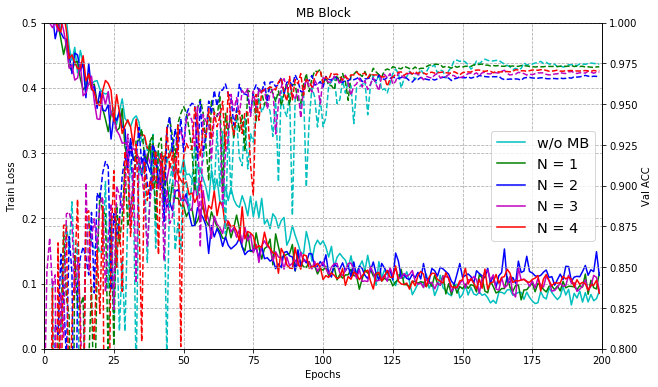

In [50]:
plt.rcParams["figure.figsize"] = (10,6)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
line1 = ax1.plot(ooutput5.history['loss'], 'c', label='w/o MB')
line2 = ax1.plot(output3.history['loss'], 'g', label='N = 1')
line3 = ax1.plot(output2.history['loss'], 'b', label='N = 2')
line4 = ax1.plot(output1.history['loss'], 'm', label='N = 3')
line5 = ax1.plot(output4.history['loss'], 'r', label='N = 4')
line6 = ax2.plot(ooutput5.history['val_acc'], 'c--', label='w/o MB')
line7 = ax2.plot(output3.history['val_acc'], 'g--', label='N = 1')
line8 = ax2.plot(output2.history['val_acc'], 'b--', label='N = 2')
line9 = ax2.plot(output1.history['val_acc'], 'm--', label='N = 3')
line10 = ax2.plot(output4.history['val_acc'], 'r--', label='N = 4')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train Loss")
ax2.set_ylabel("Val ACC")
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 0.5)
ax2.set_ylim(0.8, 1)
lines = line1 + line2 + line3 + line4 + line5
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, fontsize='x-large', loc=7)
plt.title('MB Block')
plt.grid(which='major', axis='both', linestyle='--')
ax1.grid(which='major', axis='both', linestyle='--')

In [51]:
fig.savefig("fig7.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
